<a href="https://colab.research.google.com/github/chaitanya-949/forecasting-electricity-prices/blob/main/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Liabraries

In [299]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

import warnings
from tensorflow.keras.layers import Dense, LSTM


from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import  MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from math import sqrt

warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))

In [300]:
# Read the datasets

df_weather = pd.read_csv("/content/weather_features.csv",parse_dates=['dt_iso'])

df_energy = pd.read_csv("/content/energy_dataset.csv", parse_dates=['time'])

# Energy Dataset

In [301]:
#csv view
df_energy.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [302]:
#shape of the dataframe(rows,columns)
df_energy.shape

(35064, 29)

In [303]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [304]:

# Convert time to datetime object and set it as index

df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True, infer_datetime_format=True)
#df_energy = df_energy.set_index('time')

In [305]:
# Find NaNs and duplicates in df_energy

print(df_energy.isnull().values.sum())

print(df_energy.duplicated().sum())



70529
0


In [306]:
# Find the number of NaNs in each column

df_energy.isnull().sum(axis=0)

,0
time,0
generation biomass,19
generation fossil brown coal/lignite,18
generation fossil coal-derived gas,18
generation fossil gas,18
generation fossil hard coal,18
generation fossil oil,19
generation fossil oil shale,18
generation fossil peat,18
generation geothermal,18


In [307]:
# Drop unusable columns

df_energy = df_energy.drop(['generation fossil coal-derived gas','generation fossil oil shale',
                            'generation fossil peat', 'generation geothermal',
                            'generation hydro pumped storage aggregated', 'generation marine',
                            'generation wind offshore', 'forecast wind offshore eday ahead',
                            'total load forecast', 'forecast solar day ahead',
                            'forecast wind onshore day ahead'],
                            axis=1)

In [308]:
# Fill null values using interpolation

df_energy.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

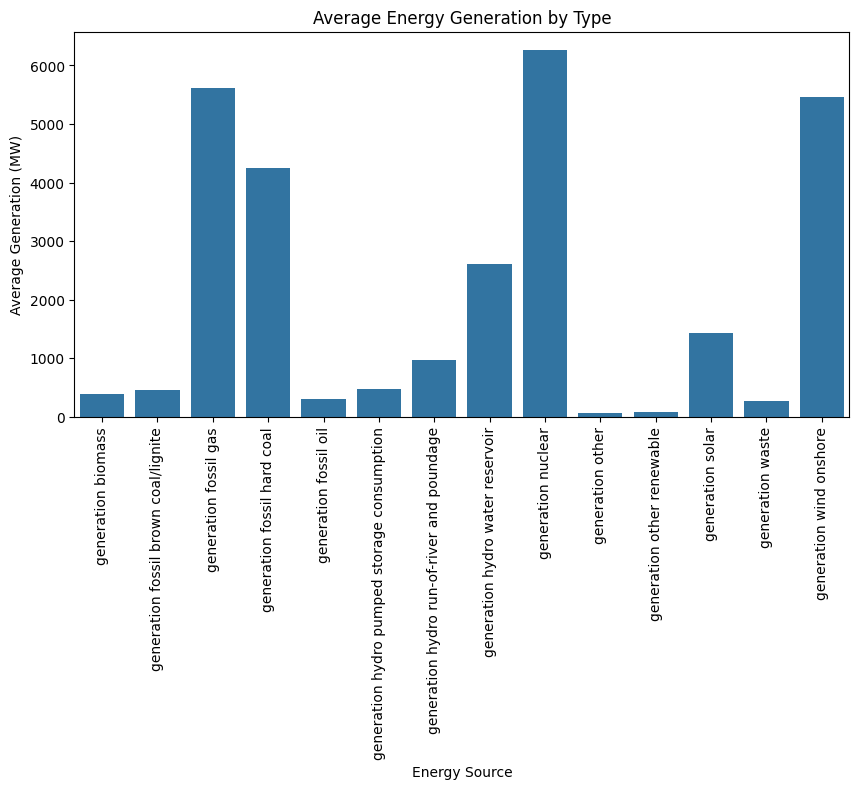

In [309]:


# Calculate average generation for selected energy sources
avg_generation = df_energy[['generation biomass', 'generation fossil brown coal/lignite',
        'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste','generation wind onshore']].mean()

plt.figure(figsize=(10,5))
sns.barplot(x=avg_generation.index, y=avg_generation.values)
plt.xlabel('Energy Source')
plt.ylabel('Average Generation (MW)')
plt.title('Average Energy Generation by Type')
plt.xticks(rotation=90)
plt.show()


<Figure size 1000x500 with 0 Axes>

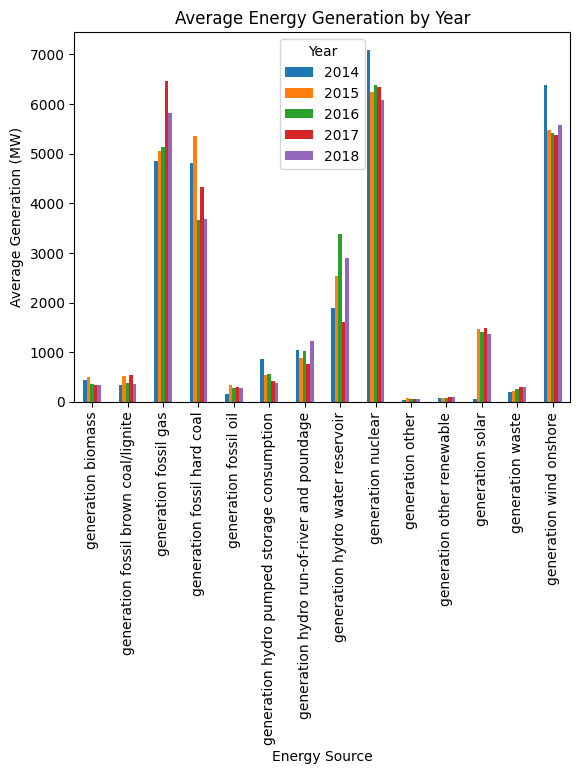

In [310]:
df_energy['year'] = pd.to_datetime(df_energy['time']).dt.year

# Group by year and calculate the average generation for each year
avg_generation_by_year = df_energy.groupby('year')[['generation biomass', 'generation fossil brown coal/lignite',
        'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste','generation wind onshore']].mean()

# Transpose the dataframe for plotting
avg_generation_by_year = avg_generation_by_year.transpose()

# Plot the average generation for each year in a bar plot
plt.figure(figsize=(10,5))
avg_generation_by_year.plot(kind='bar')
plt.xlabel('Energy Source')
plt.ylabel('Average Generation (MW)')
plt.title('Average Energy Generation by Year')
plt.xticks(rotation=90)
plt.legend(title='Year')
plt.show()


In [311]:
df_energy.set_index('time', inplace=True)
df_energy.drop("year",axis=1,inplace=True)

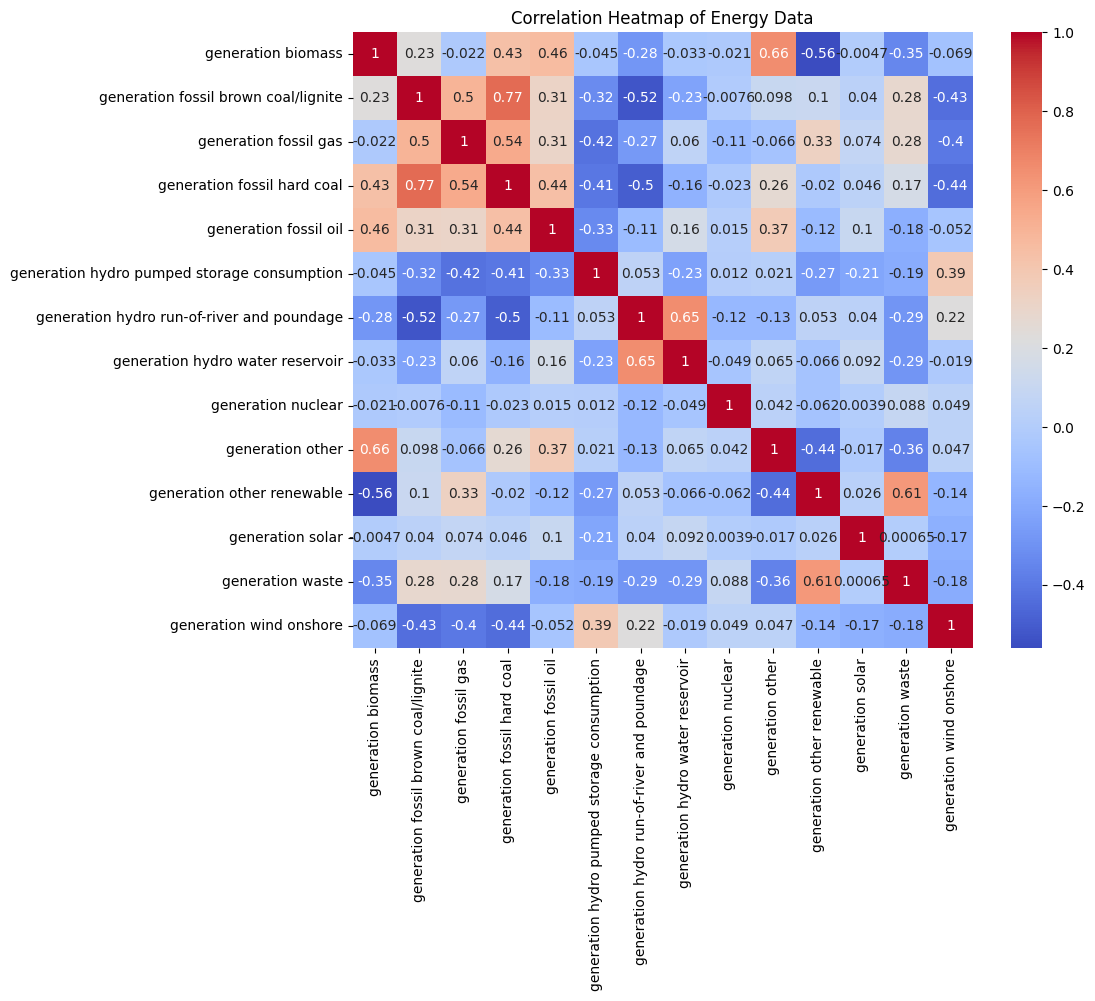

In [312]:
plt.figure(figsize=(10,8))
corr = df_energy[['generation biomass', 'generation fossil brown coal/lignite',
        'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste','generation wind onshore']].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Energy Data')
plt.show()


##weather_dataset


In [313]:
df_weather.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [314]:
df_weather.shape

(178396, 17)

In [315]:
# Print the type of each variable in df_weather

df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_id           178396 non-null  int64  
 14  weather_main         178396 non-null  object 
 15  weather_descripti

In [316]:
def df_convert_dtypes(df, convert_from, convert_to):
    cols = df.select_dtypes(include=[convert_from]).columns
    for col in cols:
        df[col] = df[col].values.astype(convert_to)
    return df

In [317]:
# Convert columns with int64 type values to float64 type

df_weather = df_convert_dtypes(df_weather, np.int64, np.float64)

In [318]:
# Convert dt_iso to datetime type, rename it and set it as index

df_weather['time'] = pd.to_datetime(df_weather['dt_iso'], utc=True, infer_datetime_format=True)
df_weather = df_weather.drop(['dt_iso'], axis=1)
df_weather = df_weather.set_index('time')

In [319]:
df_weather.describe().T

,count,mean,std,min,25%,50%,75%,max
temp,178396.0,289.618605,8.026199,262.24,283.670000,289.15,295.150000,315.600
temp_min,178396.0,288.330442,7.955491,262.24,282.483602,288.15,293.730125,315.150
temp_max,178396.0,291.091267,8.612454,262.24,284.650000,290.15,297.150000,321.150
pressure,178396.0,1069.260740,5969.631893,0.00,1013.000000,1018.00,1022.000000,1008371.000
humidity,178396.0,68.423457,21.902888,0.00,53.000000,72.00,87.000000,100.000
wind_speed,178396.0,2.470560,2.095910,0.00,1.000000,2.00,4.000000,133.000
wind_deg,178396.0,166.591190,116.611927,0.00,55.000000,177.00,270.000000,360.000
rain_1h,178396.0,0.075492,0.398847,0.00,0.000000,0.00,0.000000,12.000
rain_3h,178396.0,0.000380,0.007288,0.00,0.000000,0.00,0.000000,2.315
snow_3h,178396.0,0.004763,0.222604,0.00,0.000000,0.00,0.000000,21.500


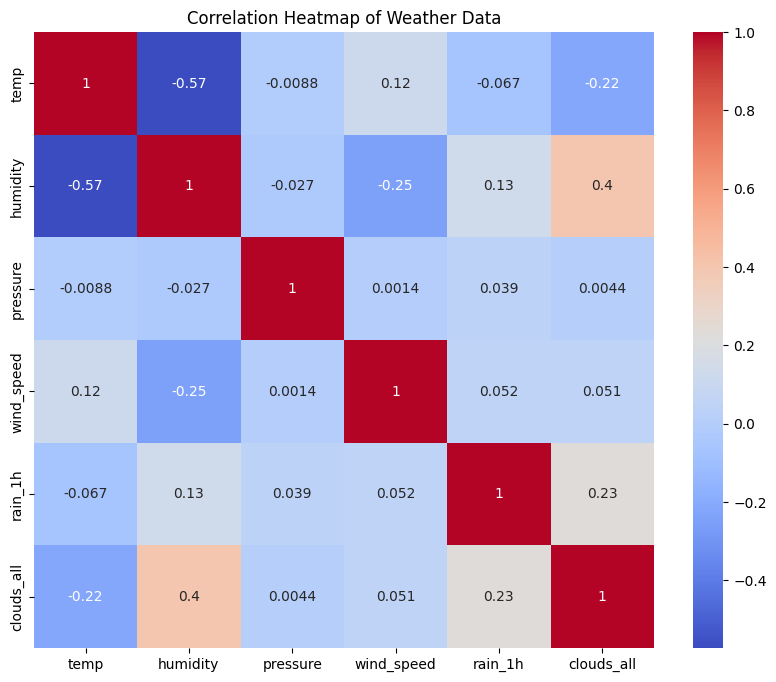

In [320]:
plt.figure(figsize=(10,8))
corr_weather = df_weather[['temp', 'humidity', 'pressure', 'wind_speed', 'rain_1h', 'clouds_all']].corr()

sns.heatmap(corr_weather, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Weather Data')
plt.show()


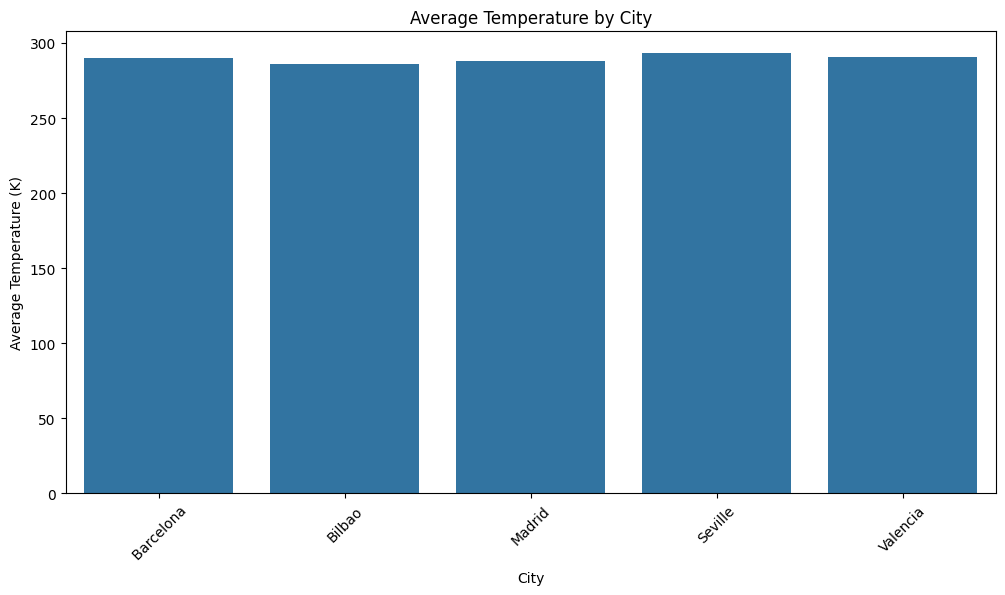

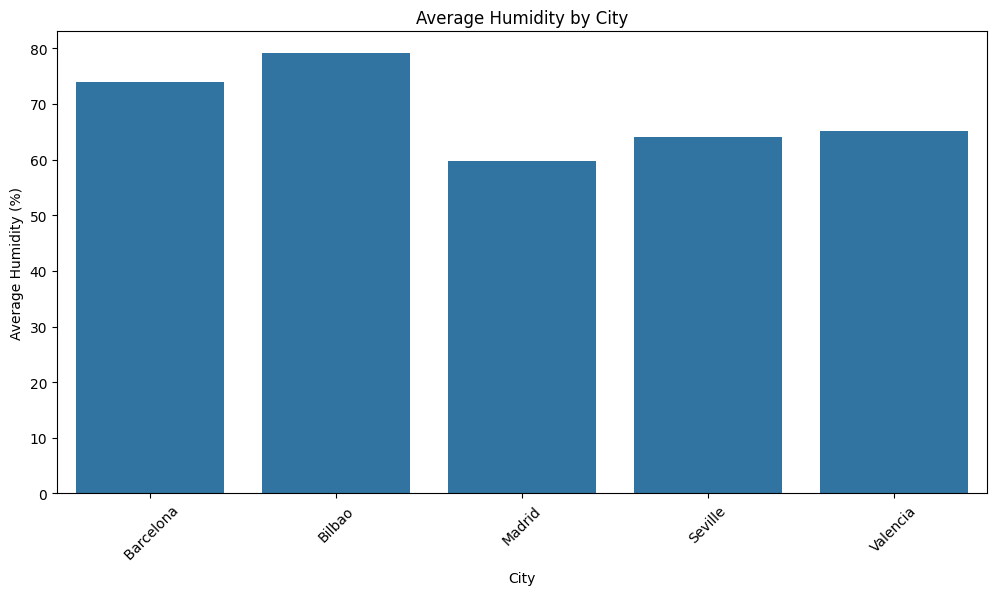

In [321]:
# Group data by city and calculate average temperature and humidity
city_avg = df_weather.groupby('city_name')[['temp', 'humidity']].mean().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x='city_name', y='temp', data=city_avg)
plt.xlabel('City')
plt.ylabel('Average Temperature (K)')
plt.title('Average Temperature by City')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(x='city_name', y='humidity', data=city_avg)
plt.xlabel('City')
plt.ylabel('Average Humidity (%)')
plt.title('Average Humidity by City')
plt.xticks(rotation=45)
plt.show()


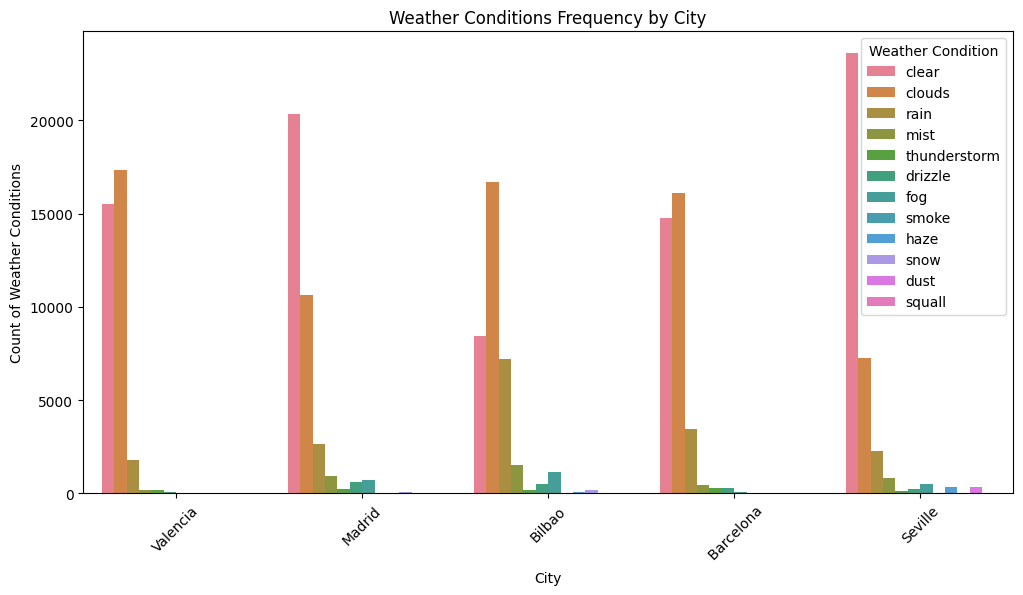

In [322]:
plt.figure(figsize=(12,6))
sns.countplot(x='city_name', hue='weather_main', data=df_weather)
plt.xlabel('City')
plt.ylabel('Count of Weather Conditions')
plt.title('Weather Conditions Frequency by City')
plt.xticks(rotation=45)
plt.legend(title='Weather Condition')
plt.show()


We have to **split** the `df_weather` dataset into 5 datasets, **one for each different city** (Madrid, Barcelona, Bilbao, Seville and Valencia). But first, let's see the average values for each column, grouped by each city (note that the 'weather_id' average has no meaning whatsoever).

In [323]:

mean_weather_by_city = df_weather.groupby('city_name').mean(numeric_only=True)
mean_weather_by_city

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
city_name,,,,,,,,,,,,
Barcelona,289.848248,288.594704,291.021987,1284.010486,73.994221,2.786588,187.188043,0.117079,0.000327,0.000000,23.229648,760.917465
Bilbao,286.378489,284.916661,288.036687,1017.567439,79.089455,1.957470,159.883536,0.123493,0.001034,0.023455,43.960697,723.943228
Madrid,288.061071,286.824877,289.155600,1011.838448,59.776932,2.441696,173.293159,0.055083,0.000129,0.000029,22.397028,762.260264
Seville,293.105431,291.184103,295.962431,1018.504711,64.140732,2.483787,151.757179,0.045392,0.000180,0.000000,14.748770,771.409849
Valencia,290.780780,290.222277,291.355025,1015.973794,65.145113,2.692815,160.753820,0.035924,0.000226,0.000154,20.820999,781.228283


In [324]:
# Find NaNs and duplicates in df_weather

print(df_weather.isnull().values.sum())

temp_weather = df_weather.duplicated(keep='first').sum()

print(temp_weather)

0
8622


In [325]:


df_weather = df_weather.reset_index().drop_duplicates(subset=['time', 'city_name'],
                                                      keep='first').set_index('time')

In [326]:
# Drop columns
df_weather = df_weather.drop([ 'weather_id','weather_description', 'weather_icon',"rain_3h",'snow_3h'], axis=1)

In [327]:
# Display the number of duplicates in df_weather

temp_weather = df_weather.reset_index().duplicated(subset=['time', 'city_name'],
                                                   keep='first').sum()
print('There are {} duplicate rows in df_weather ' \
      'based on all columns except "time" and "city_name".'.format(temp_weather))

There are 0 duplicate rows in df_weather based on all columns except "time" and "city_name".


# Handling Outliers

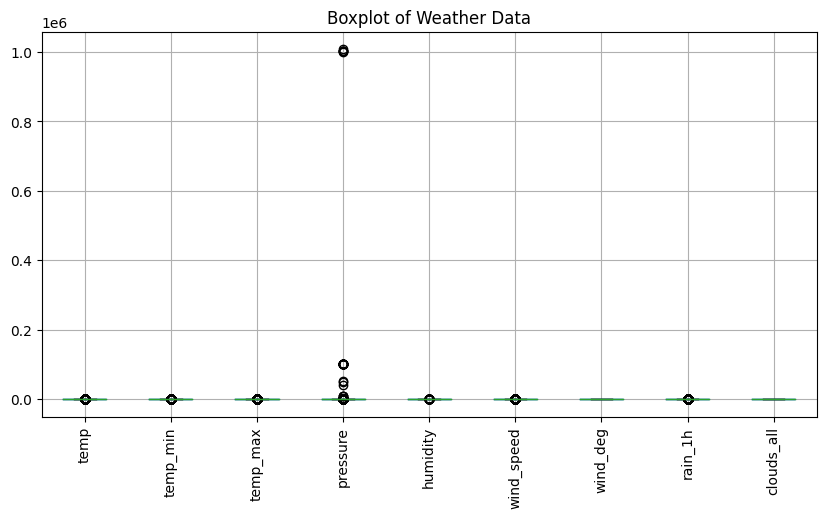

In [328]:


# Boxplot for all columns in df_weather
plt.figure(figsize=(10, 5))
df_weather.boxplot()
plt.xticks(rotation=90)
plt.title('Boxplot of Weather Data')
plt.show()


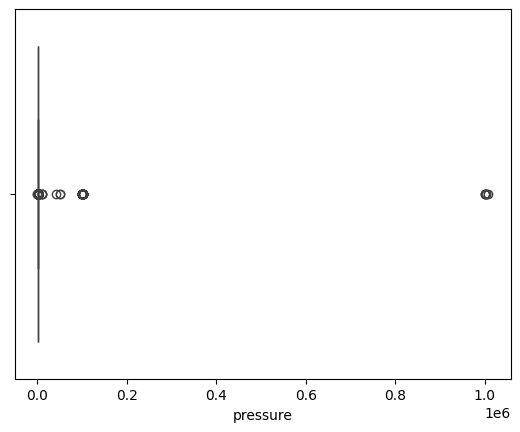

In [329]:
# Check for outliers in 'pressure' column

sns.boxplot(x=df_weather['pressure'])
plt.show()

In [330]:
# prompt: here in pressure column i wanna implement iqr and replace the values which are outliers with median

Q1 = df_weather['pressure'].quantile(0.25)
Q3 = df_weather['pressure'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

median_pressure = df_weather['pressure'].median()

df_weather['pressure'] = np.where((df_weather['pressure'] < lower_bound) | (df_weather['pressure'] > upper_bound),
                                 median_pressure, df_weather['pressure'])


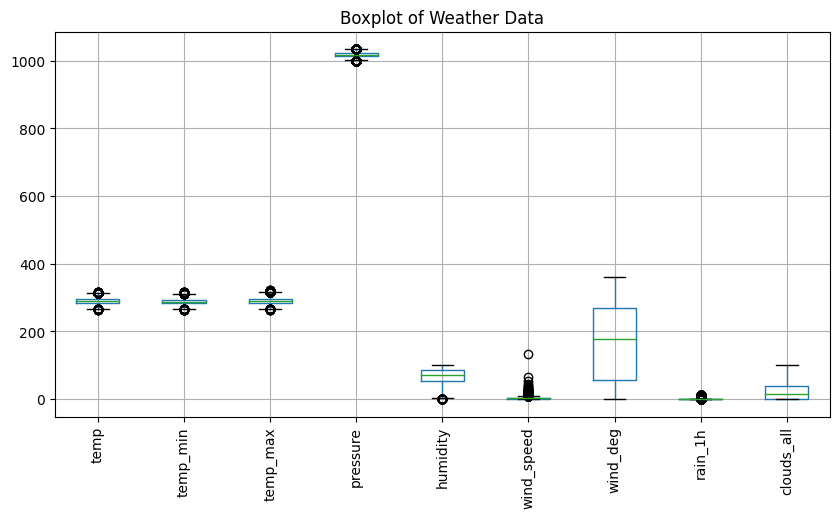

In [331]:
# Boxplot for all columns in df_weather
plt.figure(figsize=(10, 5))
df_weather.boxplot()
plt.xticks(rotation=90)
plt.title('Boxplot of Weather Data')
plt.show()

Things look a lot better regarding atmospheric pressure ('pressure') as the column has been cleaned of extreme-case outliers. What about 'wind_speed' however?

In [332]:
Q1 = df_weather['wind_speed'].quantile(0.25)
Q3 = df_weather['wind_speed'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

median_wind = df_weather['wind_speed'].median()

df_weather['wind_speed'] = np.where((df_weather['wind_speed'] < lower_bound) | (df_weather['wind_speed'] > upper_bound),
                                 median_wind, df_weather['wind_speed'])

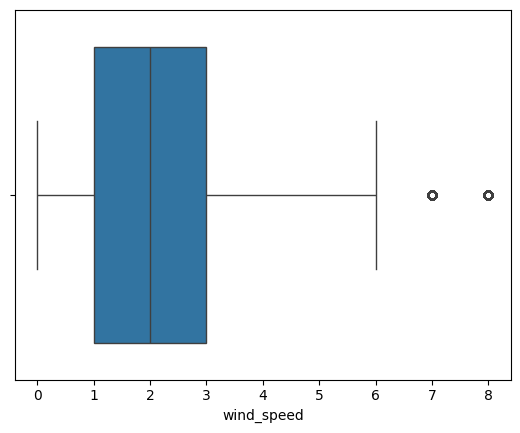

In [333]:
# Check for outliers in 'wind_speed' column

sns.boxplot(x=df_weather['wind_speed'])
plt.show()

## * One Hot Encoding

In [334]:

# encoding weather_main column
weather_main_encoded = pd.get_dummies(df_weather['weather_main'], prefix='weather_main')
df_weather = pd.concat([df_weather, weather_main_encoded], axis=1)
df_weather = df_weather.drop('weather_main', axis=1)


# merging datasets

In [335]:
# Split the df_weather into 5 dataframes (one for each city)

df_1, df_2, df_3, df_4, df_5 = [x for _, x in df_weather.groupby('city_name')]
dfs = [df_1, df_2, df_3, df_4, df_5]

In [336]:
# Merge all dataframes into the final dataframe

df_final = df_energy

for df in dfs:
    city = df['city_name'].unique()
    city_str = str(city).replace("'", "").replace('[', '').replace(']', '').replace(' ', '')
    df = df.add_suffix('_{}'.format(city_str))
    df_final = df_final.merge(df, on=['time'], how='outer')
    df_final = df_final.drop('city_name_{}'.format(city_str), axis=1)

df_final.columns

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other',
       ...
       'weather_main_drizzle_Valencia', 'weather_main_dust_Valencia',
       'weather_main_fog_Valencia', 'weather_main_haze_Valencia',
       'weather_main_mist_Valencia', 'weather_main_rain_Valencia',
       'weather_main_smoke_Valencia', 'weather_main_snow_Valencia',
       'weather_main_squall_Valencia', 'weather_main_thunderstorm_Valencia'],
      dtype='object', length=122)

In [337]:
# Display the number of NaNs and duplicates in the final dataframe

print('There are {} missing values or NaNs in df_final.'
      .format(df_final.isnull().values.sum()))

temp_final = df_final.duplicated(keep='first').sum()

print('\nThere are {} duplicate rows in df_energy based on all columns.'
      .format(temp_final))

There are 0 missing values or NaNs in df_final.

There are 0 duplicate rows in df_energy based on all columns.


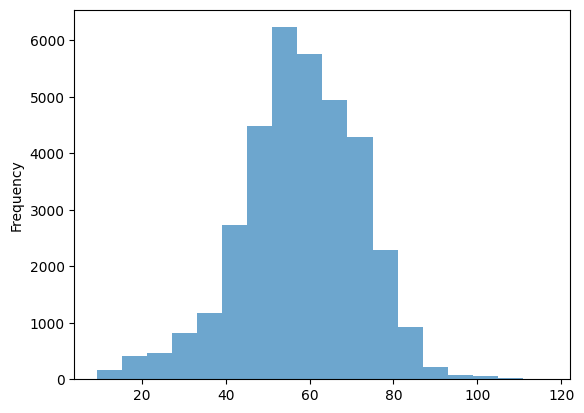

In [338]:
# Plot the histogram of the actual electricity price

ax = df_final['price actual'].plot.hist(bins=18, alpha=0.65)

In [339]:
# Generate 'hour', 'weekday' and 'month' features

for i in range(len(df_final)):
    position = df_final.index[i]
    hour = position.hour
    weekday = position.weekday()
    month = position.month
    df_final.loc[position, 'hour'] = hour
    df_final.loc[position, 'weekday'] = weekday
    df_final.loc[position, 'month'] = month

In [340]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

In [341]:
df_final.shape

(35064, 125)

# Train ,validation,Test split

In [342]:
train_end_idx = 27048
cv_end_idx = 31056
test_end_idx = 35064

In [343]:
X = df_final[df_final.columns.drop('price actual')].values
y = df_final['price actual'].values

y = y.reshape(-1, 1)

# normalizing

In [344]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

In [345]:
scaler_X.fit(X[:train_end_idx])
scaler_y.fit(y[:train_end_idx])

MinMaxScaler()

In [346]:
X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)

# Dimensionality reduction

In [347]:
pca = PCA()
X_pca = pca.fit(X_norm[:train_end_idx])

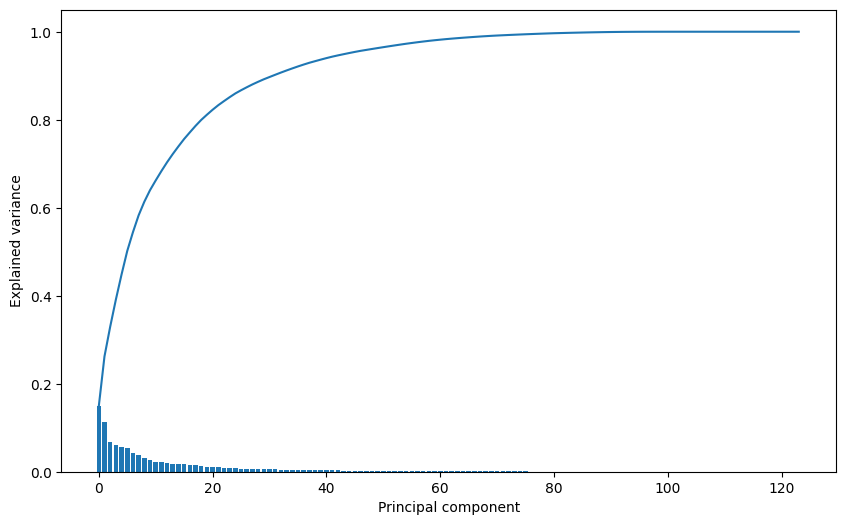

In [348]:
num_components = len(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.bar(np.arange(num_components), pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal component')
plt.ylabel('Explained variance')
plt.show()

In [349]:
pca = PCA(n_components=0.75)
pca.fit(X_norm[:train_end_idx])
X_pca = pca.transform(X_norm)

In [350]:
X_pca.shape

(35064, 16)

In [351]:
dataset_norm = np.concatenate((X_pca, y_norm), axis=1)

past_history = 24
future_target = 0

In [352]:
X_train, y_train = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                     0, train_end_idx, past_history,
                                     future_target, step=1, single_step=True)

In [353]:
X_val, y_val = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                 train_end_idx, cv_end_idx, past_history,
                                 future_target, step=1, single_step=True)

In [354]:
X_test, y_test = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                   cv_end_idx, test_end_idx, past_history,
                                   future_target, step=1, single_step=True)

In [355]:
batch_size = 32
buffer_size = 1000

In [356]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation = validation.batch(batch_size).prefetch(1)

In [357]:


input_shape = X_train.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3)

In [358]:
y_test = y_test.reshape(-1, 1)
y_test_inv = scaler_y.inverse_transform(y_test)

 Electricity Price Forecasting

In [359]:
def plot_model_rmse_and_loss(history):

    # Evaluate train and validation accuracies and losses

    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Visualize epochs vs. train and validation accuracies and losses

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')

    plt.show()

 LSTM

In [360]:
tf.keras.backend.clear_session()
from tensorflow.keras.layers import LSTM, Flatten, Dense, Dropout
multivariate_lstm = tf.keras.models.Sequential([
    LSTM(100, input_shape=input_shape,
         return_sequences=True),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.1),
    Dense(1)
])
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam



model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_lstm.keras', monitor=('val_loss'), save_best_only=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=6e-3, amsgrad=True)

multivariate_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)






In [361]:
# Compile the model with loss function and metrics
multivariate_lstm.compile(loss=loss,  # Replace 'loss' with your loss function
                          optimizer=optimizer,
                          metrics=["root_mean_squared_error"])  # Replace 'metric' with your metrics


In [362]:
history = multivariate_lstm.fit(train, epochs=120,
                                validation_data=validation,
                                callbacks=[early_stopping,
                                           model_checkpoint])

Epoch 1/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 26s 28ms/step - loss: 0.4630 - root_mean_squared_error: 0.5302 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0807
Epoch 2/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 24s 29ms/step - loss: 0.0061 - root_mean_squared_error: 0.0776 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0672
Epoch 3/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 24s 29ms/step - loss: 0.0045 - root_mean_squared_error: 0.0665 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0666
Epoch 4/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 42s 30ms/step - loss: 0.0038 - root_mean_squared_error: 0.0614 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0557
Epoch 5/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 40s 29ms/step - loss: 0.0030 - root_mean_squared_error: 0.0548 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0587
Epoch 6/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - loss: 0.0028 - root_mean_squared_error: 0.0520 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0591
Epoch 7/120
845/845 ━━━━━━━━━━━━━━

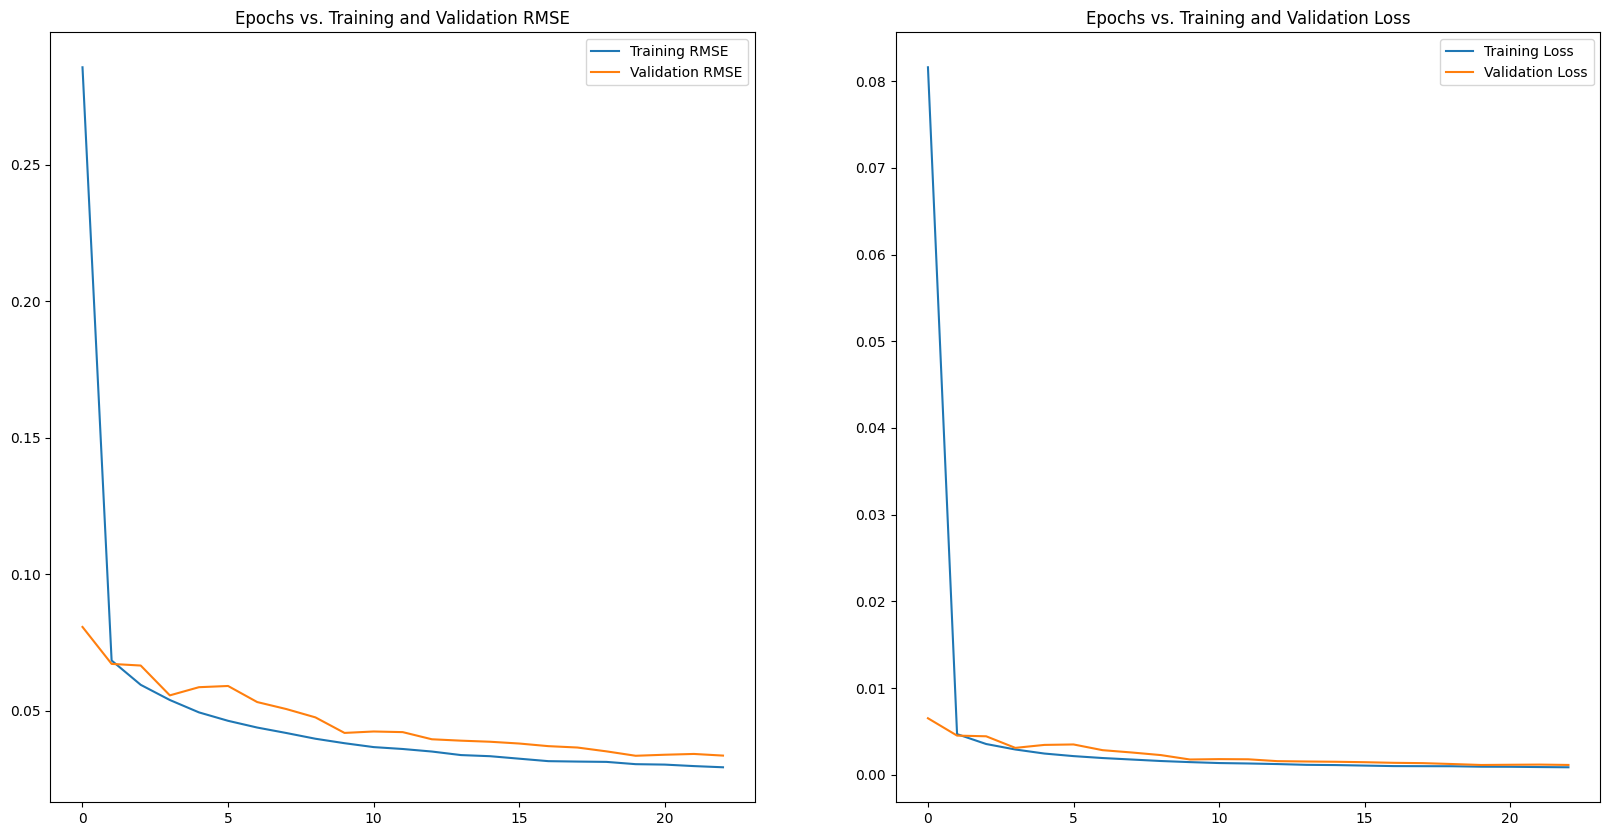

In [363]:
plot_model_rmse_and_loss(history)

In [364]:
multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.keras')

forecast = multivariate_lstm.predict(X_test)
lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_lstm = sqrt(mean_squared_error(y_test_inv,
                                    lstm_forecast))
print('RMSE of hour-ahead electricity price LSTM forecast: {}'
      .format(round(rmse_lstm, 3)))

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
RMSE of hour-ahead electricity price LSTM forecast: 2.991


In [365]:


# Assuming you have y_test_inv and lstm_forecast defined from the previous code
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_final.index[-len(y_test_inv):], y=y_test_inv.flatten(), mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=df_final.index[-len(lstm_forecast):], y=lstm_forecast.flatten(), mode='lines', name='LSTM Forecast'))

fig.update_layout(
    title="Actual vs. Forecasted Electricity Prices",
    xaxis_title="Time",
    yaxis_title="Electricity Price"
)

fig.show()


In [366]:


# Forecasted Electricity Prices Plot
fig_forecast = go.Figure()
fig_forecast.add_trace(go.Scatter(x=df_final.index[-len(lstm_forecast):], y=lstm_forecast.flatten(), mode='lines', name='LSTM Forecast'))

fig_forecast.update_layout(
    title="Forecasted Electricity Prices (LSTM)",
    xaxis_title="Time",
    yaxis_title="Electricity Price"
)

fig_forecast.show()


 Stacked LSTM

In [367]:
tf.keras.backend.clear_session()

multivariate_stacked_lstm = tf.keras.models.Sequential([
    LSTM(250, input_shape=input_shape,
         return_sequences=True),
    LSTM(150, return_sequences=True),
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_stacked_lstm.keras', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=6e-3, amsgrad=True)

multivariate_stacked_lstm.compile(loss=loss,
                                  optimizer=optimizer,
                                  metrics=metric)

In [368]:
history = multivariate_stacked_lstm.fit(train, epochs=25,
                                validation_data=validation,
                                callbacks=[early_stopping,
                                           model_checkpoint])

Epoch 1/25
845/845 ━━━━━━━━━━━━━━━━━━━━ 109s 125ms/step - loss: 1.2476 - root_mean_squared_error: 0.8838 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0825
Epoch 2/25
845/845 ━━━━━━━━━━━━━━━━━━━━ 140s 123ms/step - loss: 0.0074 - root_mean_squared_error: 0.0852 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0876
Epoch 3/25
845/845 ━━━━━━━━━━━━━━━━━━━━ 144s 125ms/step - loss: 0.0059 - root_mean_squared_error: 0.0760 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0738


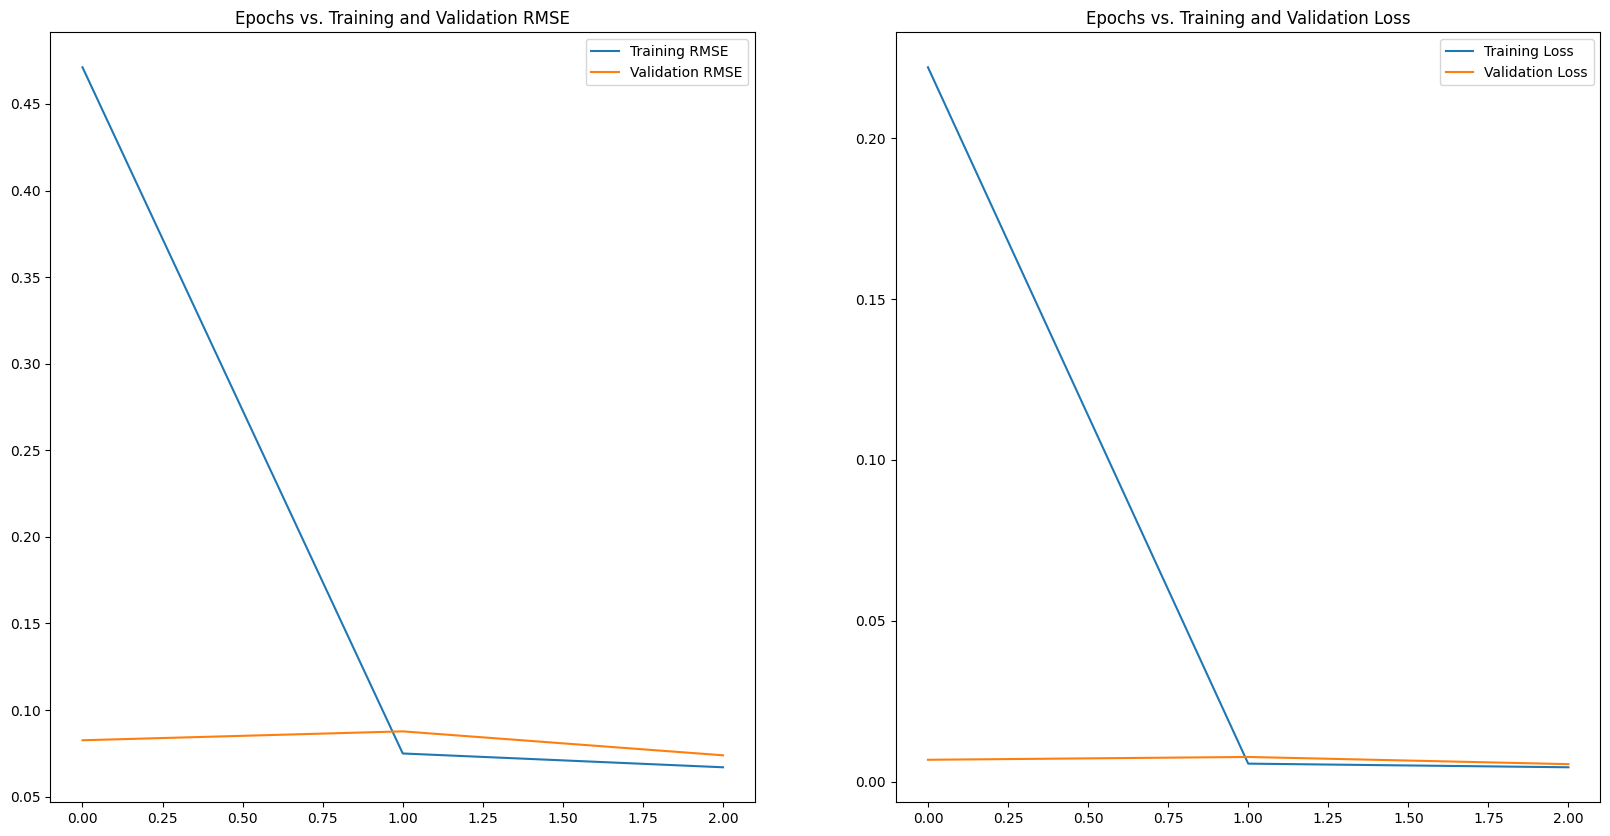

In [369]:
plot_model_rmse_and_loss(history)

In [370]:
multivariate_stacked_lstm = tf.keras.models.load_model('multivariate_stacked_lstm.keras')

forecast = multivariate_stacked_lstm.predict(X_test)
multivariate_stacked_lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_stacked_lstm = sqrt(mean_squared_error(y_test_inv,
                                                 multivariate_stacked_lstm_forecast))
print('RMSE of hour-ahead electricity price multivariate Stacked LSTM forecast: {}'
      .format(round(rmse_mult_stacked_lstm, 3)))


125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step
RMSE of hour-ahead electricity price multivariate Stacked LSTM forecast: 7.926


In [371]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_final.index[-len(y_test_inv):], y=y_test_inv.flatten(), mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=df_final.index[-len(multivariate_stacked_lstm_forecast):], y=multivariate_stacked_lstm_forecast.flatten(), mode='lines', name='stacked LSTM Forecast'))

fig.update_layout(
    title="Actual vs. Forecasted Electricity Prices",
    xaxis_title="Time",
    yaxis_title="Electricity Price"
)

fig.show()